- take a dataset (fmnist)
- train UMAP
- load pretrained network
- get latent embeddings
- intersect 

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa
import pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "cifar10"
labels_per_class = 64 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.0 # minimum confidence to include in UMAP graph for learned metric
learned_metric = True # whether to use a learned metric, or Euclidean distance between datapoints

augmented = False #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 500 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 10 # how many epochs maximum each graph trains for (without early stopping)
graph_patience = 10 # how many times without improvement to train a new graph
min_graph_delta = 0.0025 # minimum improvement on validation acc to consider an improvement for training

#### Load dataset

In [6]:
from tfumap.semisupervised_keras import load_dataset

In [7]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [8]:
from tfumap.semisupervised_keras import load_architecture

In [9]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [10]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [11]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0827 01:05:01.805665 140510964918016 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fca3ddf2908> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fca3ddf2940>).
W0827 01:05:01.808954 140510964918016 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fca3dde8518> and <tensorflow.python.keras.layers.advanced_activations.

W0827 01:05:02.124129 140510964918016 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7fca3de420f0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca3de42400>).
W0827 01:05:02.129714 140510964918016 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca3de42400> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [12]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

313/313 [==============================] - 1s 2ms/step
pretrained acc: 0.4992


### get last layer activation

In [13]:
# model to grab last layer activations
last_layer_class = tf.keras.models.Model(
    classifier.input,
    [classifier.get_layer(name=classifier.layers[-2].name).get_output_at(0)],
)

# get encoder activations for X_train
enc_z = encoder.predict(X_train)

# get last layer activations for X_train
last_layer_z = last_layer_class.predict(enc_z)

### get UMAP graphs

In [14]:
from umap import UMAP

In [15]:
embedder_last_layer = UMAP(verbose=True)
z_last_layer = embedder_last_layer.fit_transform(last_layer_z)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 01:05:21 2020 Finding Nearest Neighbors
Thu Aug 27 01:05:21 2020 Building RP forest with 15 trees
Thu Aug 27 01:05:23 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Thu Aug 27 01:05:38 2020 Finished Nearest Neighbor Search
Thu Aug 27 01:05:42 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:06:05 2020 Finished embedding


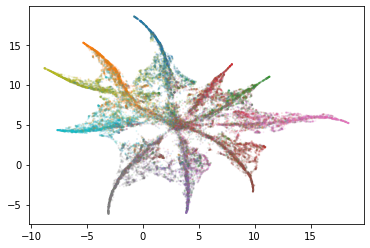

In [16]:
plt.scatter(z_last_layer[:, 0], z_last_layer[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [17]:
embedder_euc = UMAP(verbose=True)
z_x = embedder_euc.fit_transform(X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Aug 27 01:06:11 2020 Finding Nearest Neighbors
Thu Aug 27 01:06:11 2020 Building RP forest with 15 trees
Thu Aug 27 01:06:14 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Thu Aug 27 01:06:18 2020 Finished Nearest Neighbor Search
Thu Aug 27 01:06:19 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:06:43 2020 Finished embedding


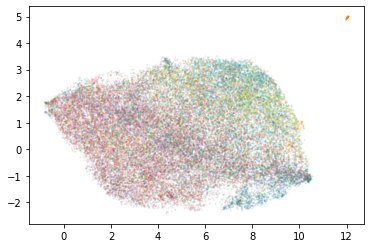

In [18]:
plt.scatter(z_x[:, 0], z_x[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [19]:
intersected_graph = embedder_euc.graph_ + embedder_last_layer.graph_ / 2

In [20]:
umap_intersect = UMAP(verbose=True, metric='precomputed')

In [21]:
# this treats probabilities as distances...
z_intersect = umap_intersect.fit_transform(intersected_graph)

/mnt/cube/tsainbur/Projects/github_repos/umap/umap/umap_.py:1632: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


UMAP(dens_frac=0.0, dens_lambda=0.0, metric='precomputed', verbose=True)
Construct fuzzy simplicial set
Computing KNNs for sparse precomputed distances...
Thu Aug 27 01:06:58 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug 27 01:07:21 2020 Finished embedding


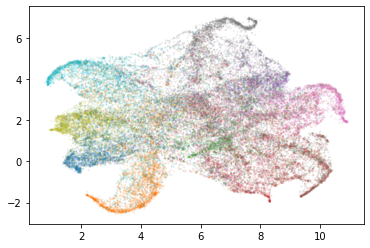

In [22]:
plt.scatter(z_intersect[:, 0], z_intersect[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [23]:
from umap.umap_ import simplicial_set_embedding, check_random_state

In [24]:
random_state = check_random_state(42)

In [25]:
embed_graph = intersected_graph
embedding_ = simplicial_set_embedding(
            embedder_euc._raw_data,  # JH why raw data?
            embed_graph,
            embedder_euc.n_components,
            embedder_euc._initial_alpha,
            embedder_euc._a,
            embedder_euc._b,
            embedder_euc.repulsion_strength,
            embedder_euc.negative_sample_rate,
            0,
            embedder_euc.init,
            random_state,
            embedder_euc._input_distance_func,
            embedder_euc._metric_kwds,
            embedder_euc.densmap,
            embedder_euc._densmap_kwds,
            embedder_euc.output_dens,
            embedder_euc._output_distance_func,
            embedder_euc._output_metric_kwds,
            embedder_euc.output_metric in ("euclidean", "l2"),
            embedder_euc.random_state is None,
            embedder_euc.verbose,
        )

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


In [26]:
embedding_[0]

array([[8.4298115, 7.2718306],
       [3.6701   , 7.000433 ],
       [2.9123113, 7.171715 ],
       ...,
       [8.010323 , 7.563292 ],
       [4.3711486, 5.494485 ],
       [3.4232416, 6.200714 ]], dtype=float32)

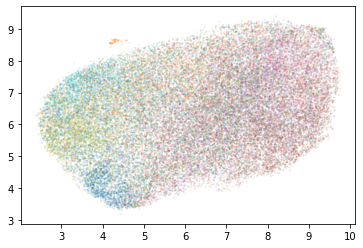

In [27]:
plt.scatter(embedding_[0][:, 0], embedding_[0][:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [28]:
intersected_graph2 = embedder_euc.graph_ + embedder_last_layer.graph_ - embedder_euc.graph_ * embedder_last_layer.graph_

In [29]:
embed_graph = intersected_graph2
embedding_, aux_data = simplicial_set_embedding(
            embedder_euc._raw_data,  # JH why raw data?
            embed_graph,
            embedder_euc.n_components,
            embedder_euc._initial_alpha,
            embedder_euc._a,
            embedder_euc._b,
            embedder_euc.repulsion_strength,
            embedder_euc.negative_sample_rate,
            0,
            embedder_euc.init,
            random_state,
            embedder_euc._input_distance_func,
            embedder_euc._metric_kwds,
            embedder_euc.densmap,
            embedder_euc._densmap_kwds,
            embedder_euc.output_dens,
            embedder_euc._output_distance_func,
            embedder_euc._output_metric_kwds,
            embedder_euc.output_metric in ("euclidean", "l2"),
            embedder_euc.random_state is None,
            embedder_euc.verbose,
        )

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


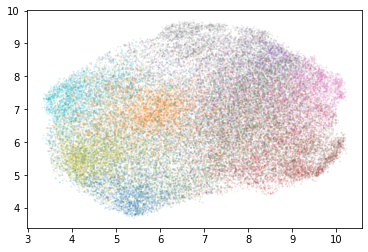

In [30]:
plt.scatter(embedding_[:, 0], embedding_[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

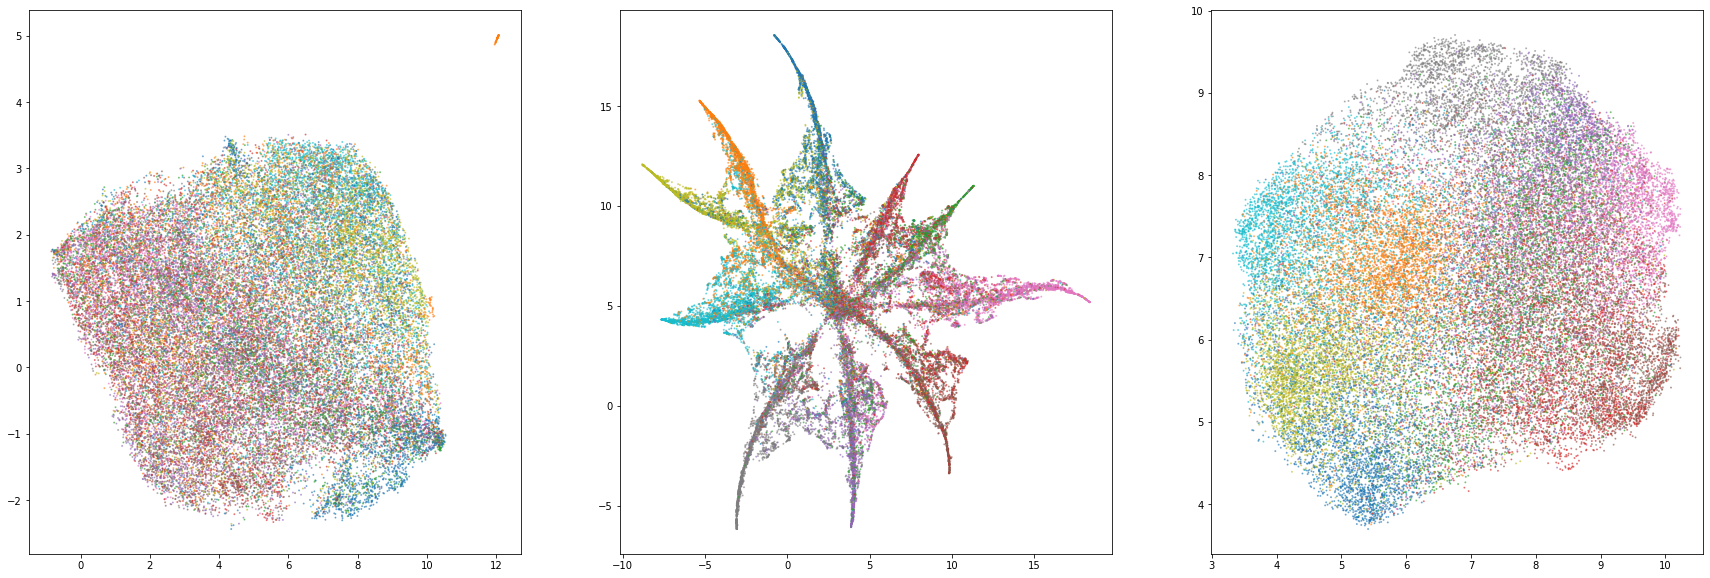

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
ax = axs[0]
ax.scatter(z_x[:, 0], z_x[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.5, cmap = plt.cm.tab10)

ax = axs[1]
ax.scatter(z_last_layer[:, 0], z_last_layer[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.5, cmap = plt.cm.tab10)

ax = axs[2]
ax.scatter(embedding_[:, 0], embedding_[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.5, cmap = plt.cm.tab10)

In [32]:
from umap.umap_ import simplicial_set_embedding

In [33]:
simplicial_set_embedding(

SyntaxError: unexpected EOF while parsing (<ipython-input-33-cce68e1c3be3>, line 1)

In [ ]:
plt.scatter(z_intersect[:, 0], z_intersect[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
umap_graph_latent = build_fuzzy_simplicial_set(data, y=Y_masked, n_neighbors=n_neighbors,)